In [1]:
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 2. 'wet_food_textures_in_order' 컬럼에서 'raw' (생식) 선호 여부 확인
# 'raw'가 포함되어 있으면 True, 아니면 False인 새로운 컬럼 생성
df['prefers_raw'] = df['wet_food_textures_in_order'].str.contains('raw', case=False, na=False)

# 3. 'pet_breed_size'에서 '큰 아이들' 정의
# 'large' 또는 'giant'가 큰 아이들이라는 가정하에, 해당 값들을 'large_or_larger'로, 나머지는 'other_size'로 분류합니다.
# 데이터셋의 실제 값을 확인하여 조정할 수 있습니다. 
# 일단, 데이터 미리보기에서 확인된 'large'와 이와 비슷한 'giant', 'extra large'를 'Large or Larger'로 간주합니다.
large_sizes = ['large', 'giant', 'extra large'] 
df['is_large_or_larger'] = df['pet_breed_size'].astype(str).str.lower().isin(large_sizes)
# 중성화 여부와 반려동물 크기 간의 관계
# normalize='index'를 사용하여 각 중성화 그룹 내에서 크기 분포의 비율 확인
size_crosstab = pd.crosstab(
    df['neutered'], 
    df['is_large_or_larger'], 
    normalize='index' # 행(neutered)을 기준으로 정규화하여 비율 계산
)

print("--- 중성화 여부와 반려동물 크기 분포 (행별 비율) ---")
# 결과 컬럼 이름 변경 (가독성 향상)
size_crosstab.columns = ['Small or Medium Size Ratio', 'Large or Larger Size Ratio']
size_crosstab.index.name = 'Neutered'
print(size_crosstab.round(4) * 100) # 백분율로 출력

# 가설 1: 중성화되지 않은 아이들은 대체로 큰 아이들일 것이다.
# False 행의 'Large or Larger Size Ratio' 비율을 확인하여 True 행의 비율과 비교합니다.

--- 중성화 여부와 반려동물 크기 분포 (행별 비율) ---
          Small or Medium Size Ratio  Large or Larger Size Ratio
Neutered                                                        
False                          73.86                       26.14
True                           76.83                       23.17


In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 1. 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 2. '생식 선호도' (prefers_raw) 컬럼 생성 및 0/1 인코딩
# 1: 생식 선호 (raw 포함), 0: 생식 미선호
df['prefers_raw'] = df['wet_food_textures_in_order'].astype(str).str.contains('raw', case=False, na=False).astype(int)

# 3. '큰 아이들' (is_large_or_larger) 컬럼 생성 및 0/1 인코딩
# 1: 크거나 큰 (large/giant/extra large), 0: 작거나 중간
large_sizes = ['large', 'giant', 'extra large'] 
df['is_large_or_larger'] = df['pet_breed_size'].astype(str).str.lower().isin(large_sizes).astype(int)

# 4. '중성화 여부' (neutered) 컬럼 0/1 인코딩 및 분석 데이터프레임 준비
# 1: 중성화함 (TRUE), 0: 중성화 안 함 (FALSE)
df_analysis = df[df['neutered'].isin([True, False])].copy()
df_analysis['neutered_encoded'] = df_analysis['neutered'].astype(int)

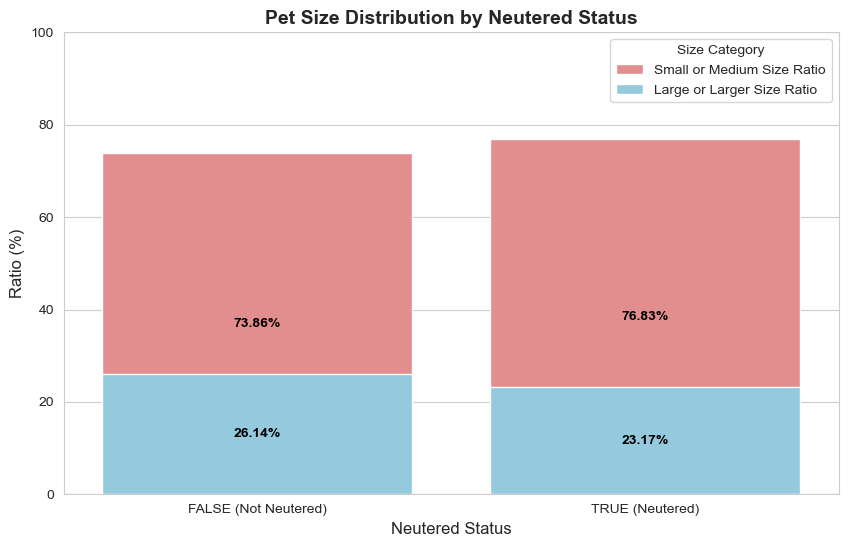

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Provided data for visualization
data = {
    'Neutered': ['False', 'True'],
    'Small or Medium Size Ratio': [73.86, 76.83],
    'Large or Larger Size Ratio': [26.14, 23.17]
}
df_plot = pd.DataFrame(data)

# Convert data to Long Format for Seaborn stacked bar plot
df_long = pd.melt(
    df_plot, 
    id_vars='Neutered', 
    var_name='Size Category', 
    value_vars=['Small or Medium Size Ratio', 'Large or Larger Size Ratio'], 
    value_name='Ratio (%)'
)

# --- Ensure correct font settings are disabled/overridden for pure English ---
# This ensures that Matplotlib doesn't try to find a failing Korean font
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = True # Default setting for minus sign

# ==========================================================
# Visualization (Stacked Bar Plot)
# ==========================================================

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the Stacked Bar Plot
barplot = sns.barplot(
    x='Neutered', 
    y='Ratio (%)', 
    hue='Size Category', 
    data=df_long, 
    palette=['lightcoral', 'skyblue'],
    dodge=False 
)

# Set Titles and Labels in English
plt.title('Pet Size Distribution by Neutered Status', fontsize=14, fontweight='bold')
plt.xlabel('Neutered Status', fontsize=12)
plt.ylabel('Ratio (%)', fontsize=12)
plt.xticks([0, 1], ['FALSE (Not Neutered)', 'TRUE (Neutered)'])
plt.legend(title='Size Category', loc='upper right')

# --- Logic to display percentage values on the bars ---
bottom_values = {'False': 0, 'True': 0}

for bar in barplot.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2.
    current_neutered = 'False' if bar.get_x() < 0.5 else 'True'
    
    if bar.get_y() == 0:
        # Small or Medium Ratio
        y = bar.get_y() + height / 2.
        bottom_values[current_neutered] = height
    else:
        # Large or Larger Ratio
        y = bottom_values[current_neutered] + height / 2.
    
    # Annotate text
    if height > 0.01:
        barplot.annotate(f'{height:.2f}%', 
                           (x, y), 
                           ha='center', va='center',
                           fontsize=10, color='black',
                           fontweight='bold')

plt.ylim(0, 100)
plt.show()

In [4]:
# 종속 변수: is_large_or_larger (크기), 설명 변수: C(neutered_encoded) (중성화 여부)
model_size = logit('is_large_or_larger ~ C(neutered_encoded)', data=df_analysis).fit()

print("--- 2-1. 반려동물 크기에 대한 로지스틱 회귀 분석 결과 ---")
print(model_size.summary())
print("\n" + "="*50)

# 2-2. 오즈비(Odds Ratio) 계산 및 출력
# 오즈비는 회귀 계수(coef)를 지수화(np.exp)하여 구합니다.
odds_ratio_size = np.exp(model_size.params)
print("--- 2-2. 반려동물 크기에 대한 오즈비(Odds Ratio) ---")
print(odds_ratio_size)

Optimization terminated successfully.
         Current function value: 0.555886
         Iterations 5
--- 2-1. 반려동물 크기에 대한 로지스틱 회귀 분석 결과 ---
                           Logit Regression Results                           
Dep. Variable:     is_large_or_larger   No. Observations:                49042
Model:                          Logit   Df Residuals:                    49040
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                0.001050
Time:                        14:17:00   Log-Likelihood:                -27262.
converged:                       True   LL-Null:                       -27290.
Covariance Type:            nonrobust   LLR p-value:                 3.704e-14
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0389      

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 1. 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 2. 분석에 필요한 컬럼 정제 및 0/1 인코딩

# A. 종속 변수 인코딩 및 정제 (가장 중요!)
# 'ate_wet_food_pre_tails'가 TRUE/FALSE인 행만 남기고 1/0으로 인코딩
df['ate_wet_food_pre_tails_encoded'] = df['ate_wet_food_pre_tails'].map({True: 1, False: 0})
df_clean = df.dropna(subset=['ate_wet_food_pre_tails_encoded']).copy()

# B. 독립 변수 정제
# 'neutered'와 'gender'가 TRUE/FALSE 또는 male/female인 행만 남김
df_clean = df_clean[df_clean['neutered'].isin([True, False])]
df_clean = df_clean[df_clean['gender'].isin(['male', 'female'])]
# 'pet_life_stage_at_order'에 'Null & Default' 같은 이상값이 있다면 제거
# 여기서는 NaN만 제거합니다.
df_clean = df_clean.dropna(subset=['pet_life_stage_at_order'])


# 3. 로지스틱 회귀 분석 재실행 (인코딩된 종속 변수 사용)
# C()는 statsmodels에게 해당 변수를 범주형으로 처리하라고 지시합니다.
model_raw_fixed = logit('ate_wet_food_pre_tails_encoded ~ C(pet_breed_size) + C(pet_life_stage_at_order) + C(gender) + C(neutered)', 
                        data=df_clean).fit()

print("--- 3-1. (정제 후) 습식 사료 경험에 대한 로지스틱 회귀 분석 결과 ---")
print(model_raw_fixed.summary())
print("\n" + "="*50)

# 3-2. 오즈비(Odds Ratio) 계산 및 출력
odds_ratio_raw_fixed = np.exp(model_raw_fixed.params)
print("--- 3-2. (정제 후) 습식 사료 경험에 대한 오즈비(Odds Ratio) ---")
print(odds_ratio_raw_fixed)

Optimization terminated successfully.
         Current function value: 0.638031
         Iterations 5
--- 3-1. (정제 후) 습식 사료 경험에 대한 로지스틱 회귀 분석 결과 ---
                                 Logit Regression Results                                 
Dep. Variable:     ate_wet_food_pre_tails_encoded   No. Observations:                49042
Model:                                      Logit   Df Residuals:                    49032
Method:                                       MLE   Df Model:                            9
Date:                            Tue, 11 Nov 2025   Pseudo R-squ.:                 0.02578
Time:                                    14:17:01   Log-Likelihood:                -31290.
converged:                                   True   LL-Null:                       -32118.
Covariance Type:                        nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------

중성화: $\mathbf{중성화되지 않은}$ 아이들이 습식 사료/생식을 더 선호합니다.크기: small, toy일수록 습식 사료/생식을 강하게 선호하며, 큰 품종일수록 선호도가 낮아집니다.성장 단계: 나이가 많은 ($\text{senior}, \text{mature}$) 아이들일수록 습식 사료/생식을 압도적으로 선호합니다.

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 1. 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 2. 종속 변수 '생식 선호도' (wet_kcal > 0) 정의 및 0/1 인코딩
df['wet_kcal'] = df['wet_kcal'].fillna(0)
df['prefers_wet_food_by_kcal'] = np.where(df['wet_kcal'] > 0, 1, 0)

# 3. 'pet_breed_size' 재정의 및 그룹화 (Public Large 생성)
def group_pet_size(size):
    size = str(size).lower()
    large_group = ['large', 'extra large', 'giant']
    if size in large_group:
        return 'Public Large'
    elif size in ['small', 'medium', 'toy']:
        return size
    else:
        return np.nan # Null & Default 등 제외

df['pet_breed_size_grouped'] = df['pet_breed_size'].apply(group_pet_size)

# 4. 분석용 데이터프레임 정제
required_cols = ['prefers_wet_food_by_kcal', 'pet_breed_size_grouped', 'pet_life_stage_at_order', 'neutered']
df_analysis = df[required_cols].copy()

# 독립 변수 정제: Null 값 및 비표준 값 제거
df_analysis = df_analysis[df_analysis['neutered'].isin([True, False])]
df_analysis = df_analysis.dropna()

In [7]:
df

,customer_id,pet_id,pet_order_number,wet_food_order_number,orders_since_first_wet_trays_order,pet_has_active_subscription,pet_food_tier,pet_signup_datetime,pet_allergen_list,pet_fav_flavour_list,...,total_web_sessions,total_web_sessions_since_last_order,total_minutes_on_website,total_minutes_on_website_since_last_order,total_wet_food_updates,total_wet_food_updates_since_last_order,last_customer_support_ticket_date,customer_support_ticket_category,prefers_wet_food_by_kcal,pet_breed_size_grouped
0,10574848487411271014,4.466839e+18,2,1.0,1.0,True,superpremium,00:01.6,NaN,Chicken,...,6,4,101,32,0,0,2019-03-16 09:10:12+00:00,proactive,1,Public Large
1,10574848487411271014,4.466839e+18,1,NaN,NaN,True,superpremium,00:01.6,NaN,Chicken,...,2,1,69,3,0,0,2019-03-16 09:10:12+00:00,proactive,0,Public Large
2,10574848487411271014,4.466839e+18,8,7.0,7.0,True,superpremium,00:01.6,NaN,Chicken,...,18,0,184,0,0,0,2019-10-26 06:10:13+00:00,account,1,Public Large
3,10574848487411271014,4.466839e+18,4,3.0,3.0,True,superpremium,00:01.6,NaN,Chicken,...,13,6,130,15,0,0,2019-04-23 06:28:12+00:00,account,1,Public Large
4,10574848487411271014,4.466839e+18,9,8.0,8.0,True,superpremium,00:01.6,NaN,Chicken,...,19,1,184,0,0,0,2019-10-26 06:10:13+00:00,account,1,Public Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49037,1602644382369102712,2.984998e+18,1,NaN,NaN,True,superpremium,00:01.6,beef dairy egg soya wheat,NaN,...,2,2,3,3,0,0,2019-08-08 14:36:23+00:00,account,0,medium
49038,14508867151972863489,7.874266e+18,1,NaN,NaN,False,superpremium,00:01.6,NaN,NaN,...,1,0,24,0,0,0,NaN,NaN,0,small
49039,2727061752335930686,8.164902e+18,1,NaN,NaN,False,premium,00:01.6,NaN,Beef Lamb,...,2,0,44,0,0,0,2019-11-19 10:41:09+00:00,sign_up,0,small
49040,13468469054368461493,1.721295e+19,1,1.0,1.0,False,mid,00:01.6,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,1,toy


In [8]:
# 종속 변수: prefers_wet_food_by_kcal
# 설명 변수: pet_breed_size_grouped, pet_life_stage_at_order, neutered
# 'Public Large'가 pet_breed_size_grouped의 알파벳 순서상 첫 번째로 배치될 경우 기준 그룹이 됩니다.
model_re_run = logit('prefers_wet_food_by_kcal ~ C(pet_breed_size_grouped) + C(pet_life_stage_at_order) + C(neutered)', 
                     data=df_analysis).fit()

print("--- 2-1. (Public Large 그룹화 후) 습식 사료 선호도에 대한 로지스틱 회귀 분석 결과 ---")
print(model_re_run.summary())
print("\n" + "="*50)

# 2-2. 오즈비(Odds Ratio) 계산 및 출력
odds_ratio_re_run = np.exp(model_re_run.params)
print("--- 2-2. (Public Large 그룹화 후) 습식 사료 선호도에 대한 오즈비(Odds Ratio) ---")
print(odds_ratio_re_run)

Optimization terminated successfully.
         Current function value: 0.541326
         Iterations 8
--- 2-1. (Public Large 그룹화 후) 습식 사료 선호도에 대한 로지스틱 회귀 분석 결과 ---
                              Logit Regression Results                              
Dep. Variable:     prefers_wet_food_by_kcal   No. Observations:                49042
Model:                                Logit   Df Residuals:                    49034
Method:                                 MLE   Df Model:                            7
Date:                      Tue, 11 Nov 2025   Pseudo R-squ.:                 0.05667
Time:                              14:17:02   Log-Likelihood:                -26548.
converged:                             True   LL-Null:                       -28143.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 1. 데이터 불러오기 및 전처리 (이전과 동일)
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 종속 변수 '생식 선호도' (wet_kcal > 0) 정의 및 0/1 인코딩
df['wet_kcal'] = df['wet_kcal'].fillna(0)
df['prefers_wet_food_by_kcal'] = np.where(df['wet_kcal'] > 0, 1, 0)

# 'pet_breed_size' 재정의 및 그룹화 (Public Large 생성)
def group_pet_size(size):
    size = str(size).lower()
    large_group = ['large', 'extra large', 'giant']
    if size in large_group:
        return 'Public Large'
    elif size in ['small', 'medium', 'toy']:
        return size
    else:
        return np.nan 

df['pet_breed_size_grouped'] = df['pet_breed_size'].apply(group_pet_size)

# 분석용 데이터프레임 정제
required_cols = ['prefers_wet_food_by_kcal', 'pet_breed_size_grouped', 'pet_life_stage_at_order', 'neutered']
df_analysis = df[required_cols].copy()
df_analysis = df_analysis[df_analysis['neutered'].isin([True, False])]
df_analysis = df_analysis.dropna()

# 2. 로지스틱 회귀 분석 재실행: 'toy'를 크기 변수의 기준 그룹으로 설정
# Treatment(reference='toy')를 사용하여 'toy' 그룹이 기준이 되도록 지정
model_ref_toy = logit('''prefers_wet_food_by_kcal ~ 
                           C(pet_breed_size_grouped, Treatment(reference='toy')) + 
                           C(pet_life_stage_at_order) + 
                           C(neutered)''', 
                     data=df_analysis).fit()

print("--- 2-1. (Toy 기준) 습식 사료 선호도에 대한 로지스틱 회귀 분석 결과 ---")
print(model_ref_toy.summary())
print("\n" + "="*50)

# 2-2. 오즈비(Odds Ratio) 계산 및 출력
odds_ratio_ref_toy = np.exp(model_ref_toy.params)
print("--- 2-2. (Toy 기준) 습식 사료 선호도에 대한 오즈비(Odds Ratio) ---")
print(odds_ratio_ref_toy)

Optimization terminated successfully.
         Current function value: 0.541326
         Iterations 8
--- 2-1. (Toy 기준) 습식 사료 선호도에 대한 로지스틱 회귀 분석 결과 ---
                              Logit Regression Results                              
Dep. Variable:     prefers_wet_food_by_kcal   No. Observations:                49042
Model:                                Logit   Df Residuals:                    49034
Method:                                 MLE   Df Model:                            7
Date:                      Tue, 11 Nov 2025   Pseudo R-squ.:                 0.05667
Time:                              14:17:03   Log-Likelihood:                -26548.
converged:                             True   LL-Null:                       -28143.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

어린 애들 가설

In [10]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# 데이터 불러오기 및 전처리 (이전과 동일)
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

required_cols = [
    'pet_life_stage_at_order', 
    'ate_wet_food_pre_tails', 
    'total_web_sessions', 
    'total_minutes_on_website', 
]
df_analysis = df[required_cols].dropna().copy()

# 1. '어린 아이들' 정의
young_stages = ['junior', 'weaning']
df_analysis['is_young'] = df_analysis['pet_life_stage_at_order'].isin(young_stages)

# 2. 새로운 종속 변수 정의 (Young이면서 AND 생식 경험이 FALSE인 경우 = True(1))
df_analysis['is_young_and_no_wet_food'] = np.where(
    (df_analysis['is_young'] == True) & (df_analysis['ate_wet_food_pre_tails'] == False),
    1, # Young & No Wet Food Experience (Success)
    0  # Otherwise (Failure)
)

# 독립 변수(웹 활동량)의 척도 문제 해결: 표준화 (Z-Score)
# 회귀 모델의 안정성과 해석 용이성을 위해 표준화합니다.
df_analysis['web_sessions_std'] = (df_analysis['total_web_sessions'] - df_analysis['total_web_sessions'].mean()) / df_analysis['total_web_sessions'].std()
df_analysis['minutes_on_website_std'] = (df_analysis['total_minutes_on_website'] - df_analysis['total_minutes_on_website'].mean()) / df_analysis['total_minutes_on_website'].std()

In [11]:
# 모델: is_young_and_no_wet_food ~ web_sessions_std + minutes_on_website_std
logit_combined_model = logit('''is_young_and_no_wet_food ~ 
                                 web_sessions_std + 
                                 minutes_on_website_std''', 
                             data=df_analysis).fit(disp=False)

print("--- 2-3. [로지스틱 회귀] 웹 활동량으로 'Young & 경험 없음' 예측 ---")
print(logit_combined_model.summary())

# 오즈비 계산 (exp(coef))
odds_ratio_combined = np.exp(logit_combined_model.params)
print("\n--- 2-4. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_combined)

--- 2-3. [로지스틱 회귀] 웹 활동량으로 'Young & 경험 없음' 예측 ---
                              Logit Regression Results                              
Dep. Variable:     is_young_and_no_wet_food   No. Observations:                49042
Model:                                Logit   Df Residuals:                    49039
Method:                                 MLE   Df Model:                            2
Date:                      Tue, 11 Nov 2025   Pseudo R-squ.:                 0.03691
Time:                              14:17:03   Log-Likelihood:                -9860.5
converged:                             True   LL-Null:                       -10238.
Covariance Type:                  nonrobust   LLR p-value:                7.838e-165
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.0964      0.026   -118.545      0.000      -3.148      -3.0

In [12]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# 데이터 불러오기 및 전처리
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

required_cols = [
    'pet_life_stage_at_order', 
    'signup_promo'
]
df_analysis = df[required_cols].dropna().copy()

# 1. '어린 아이들' 그룹 정의 (기준: Other Stages)
young_stages = ['junior', 'weaning']
df_analysis['is_young'] = df_analysis['pet_life_stage_at_order'].apply(
    lambda x: 'Young' if x in young_stages else 'Other Stages'
)

# 2. '이벤트/프로모션' 유입 채널 정의 (종속 변수)
def is_event_promo(promo):
    promo = str(promo).lower()
    # 'event', 'campaign', 'promo' 단어가 포함된 채널을 이벤트 유입으로 간주
    if 'event' in promo or 'campaign' in promo or 'promo' in promo:
        return 1
    return 0

df_analysis['is_event_promo_signup'] = df_analysis['signup_promo'].apply(is_event_promo)

In [13]:
# 모델: is_event_promo_signup ~ C(is_young, Treatment(reference='Other Stages'))
# Other Stages가 기준 그룹이 됩니다.
logit_promo_model = logit('''is_event_promo_signup ~ 
                             C(is_young, Treatment(reference='Other Stages'))''', 
                          data=df_analysis).fit(disp=False)

print("--- 2-3. [로지스틱 회귀] 어린 반려동물 그룹의 이벤트 유입 예측 ---")
print(logit_promo_model.summary())

# 오즈비 계산 (exp(coef))
odds_ratio_promo = np.exp(logit_promo_model.params)
print("\n--- 2-4. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_promo)

--- 2-3. [로지스틱 회귀] 어린 반려동물 그룹의 이벤트 유입 예측 ---
                             Logit Regression Results                            
Dep. Variable:     is_event_promo_signup   No. Observations:                49042
Model:                             Logit   Df Residuals:                    49040
Method:                              MLE   Df Model:                            1
Date:                   Tue, 11 Nov 2025   Pseudo R-squ.:                0.007738
Time:                           14:17:03   Log-Likelihood:                -10185.
converged:                          True   LL-Null:                       -10264.
Covariance Type:               nonrobust   LLR p-value:                 2.023e-36
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                      

In [14]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# 데이터 불러오기 및 전처리
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

required_cols = [
    'pet_life_stage_at_order', 
    'signup_promo',
    'total_web_sessions', 
    'total_minutes_on_website', 
]
df_analysis = df[required_cols].dropna().copy()

# 1. 종속 변수 정의: '이벤트/프로모션' 유입 여부 (1 = 이벤트/프로모션)
def is_event_promo(promo):
    promo = str(promo).lower()
    if 'event' in promo or 'campaign' in promo or 'promo' in promo:
        return 1
    return 0

df_analysis['is_event_promo_signup'] = df_analysis['signup_promo'].apply(is_event_promo)

# 2. 독립 변수 정의 및 인코딩/표준화
# 2-1. 어린 반려동물 그룹 (Young = 1, Other Stages = 0)
young_stages = ['junior', 'weaning']
df_analysis['is_young_encoded'] = df_analysis['pet_life_stage_at_order'].apply(
    lambda x: 1 if x in young_stages else 0
)

# 2-2. 웹 활동 변수 표준화 (Z-Score)
df_analysis['web_sessions_std'] = (df_analysis['total_web_sessions'] - df_analysis['total_web_sessions'].mean()) / df_analysis['total_web_sessions'].std()
df_analysis['minutes_on_website_std'] = (df_analysis['total_minutes_on_website'] - df_analysis['total_minutes_on_website'].mean()) / df_analysis['total_minutes_on_website'].std()

# 3. 모델 실행
# 종속 변수: is_event_promo_signup
# 독립 변수: is_young_encoded + web_sessions_std + minutes_on_website_std
logit_promo_combined_model = logit('''is_event_promo_signup ~ 
                                      is_young_encoded + 
                                      web_sessions_std + 
                                      minutes_on_website_std''', 
                                  data=df_analysis).fit(disp=False)

print("--- 1-1. [로지스틱 회귀] 이벤트 유입(종속) 예측 ---")
print(logit_promo_combined_model.summary())

# 오즈비 계산 (exp(coef))
odds_ratio_promo_combined = np.exp(logit_promo_combined_model.params)
print("\n--- 1-2. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_promo_combined)

--- 1-1. [로지스틱 회귀] 이벤트 유입(종속) 예측 ---
                             Logit Regression Results                            
Dep. Variable:     is_event_promo_signup   No. Observations:                49042
Model:                             Logit   Df Residuals:                    49038
Method:                              MLE   Df Model:                            3
Date:                   Tue, 11 Nov 2025   Pseudo R-squ.:                 0.02072
Time:                           14:17:04   Log-Likelihood:                -10052.
converged:                          True   LL-Null:                       -10264.
Covariance Type:               nonrobust   LLR p-value:                 7.174e-92
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.8926      0.023   -128.530      0.000      -2.937      -2.848
is_young_encoded          -1.4661 

In [15]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# 데이터 불러오기 및 전처리
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

required_cols = [
    'pet_life_stage_at_order', 
    'signup_promo',
    'total_web_sessions', 
    'total_minutes_on_website', 
]
df_analysis = df[required_cols].dropna().copy()

# 1. 종속 변수 정의: 'Young' 그룹 여부 (1 = Young, 0 = Other Stages)
young_stages = ['junior', 'weaning']
df_analysis['is_young'] = df_analysis['pet_life_stage_at_order'].apply(
    lambda x: 1 if x in young_stages else 0
)

# 2. 독립 변수 정의 및 인코딩/표준화
# 2-1. 이벤트/프로모션 유입 여부 (1 = 이벤트/프로모션)
def is_event_promo(promo):
    promo = str(promo).lower()
    if 'event' in promo or 'campaign' in promo or 'promo' in promo:
        return 1
    return 0
df_analysis['is_event_promo_signup'] = df_analysis['signup_promo'].apply(is_event_promo)

# 2-2. 웹 활동 변수 표준화 (Z-Score)
df_analysis['web_sessions_std'] = (df_analysis['total_web_sessions'] - df_analysis['total_web_sessions'].mean()) / df_analysis['total_web_sessions'].std()
df_analysis['minutes_on_website_std'] = (df_analysis['total_minutes_on_website'] - df_analysis['total_minutes_on_website'].mean()) / df_analysis['total_minutes_on_website'].std()

# 3. 모델 실행
# 종속 변수: is_young
# 독립 변수: is_event_promo_signup + web_sessions_std + minutes_on_website_std
logit_combined_to_young_model = logit('''is_young ~ 
                                         is_event_promo_signup + 
                                         web_sessions_std + 
                                         minutes_on_website_std''', 
                                      data=df_analysis).fit(disp=False)

print("--- 1-1. [로지스틱 회귀] 웹 활동량과 유입으로 '어린 반려동물 그룹' 예측 ---")
print(logit_combined_to_young_model.summary())

# 오즈비 계산 (exp(coef))
odds_ratio_combined_to_young = np.exp(logit_combined_to_young_model.params)
print("\n--- 1-2. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_combined_to_young)

--- 1-1. [로지스틱 회귀] 웹 활동량과 유입으로 '어린 반려동물 그룹' 예측 ---
                           Logit Regression Results                           
Dep. Variable:               is_young   No. Observations:                49042
Model:                          Logit   Df Residuals:                    49038
Method:                           MLE   Df Model:                            3
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.04804
Time:                        14:17:04   Log-Likelihood:                -11728.
converged:                       True   LL-Null:                       -12320.
Covariance Type:            nonrobust   LLR p-value:                2.673e-256
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.7949      0.024   -118.267      0.000      -2.841      -2.749
is_event_promo_signup     -1.4391      0.150

노령견

In [16]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 1. 분석에 필요한 칼럼 선택 및 결측치 처리
required_cols = [
    'pet_life_stage_at_order', 
    'pet_allergen_list', 
    'total_web_sessions', 
    'total_minutes_on_website', 
    'customer_support_ticket_category' # 문의 카테고리 사용
]
# 결측치 제거 기준: 필수 변수 (카테고리 변수 제외)
df_analysis = df[required_cols].dropna(subset=required_cols[:-1]).copy() 
df_analysis['customer_support_ticket_category'] = df_analysis['customer_support_ticket_category'].fillna('') # 문의가 없는 경우 빈 문자열로 대체

# 2-1. 노령견 그룹 (is_senior) 정의
df_analysis['is_senior'] = df_analysis['pet_life_stage_at_order'].apply(
    lambda x: 1 if x == 'senior' else 0
)

# 2-2. 알레르기 그룹 (has_allergy) 정의
def has_allergy(allergen_list):
    return 0 if pd.isna(allergen_list) or str(allergen_list).strip().lower() in ['', 'none', 'null & default'] else 1

df_analysis['has_allergy'] = df_analysis['pet_allergen_list'].apply(has_allergy)

# 2. 독립 변수 재정의: 건강 관련 문의 유무 (is_health_ticket)
health_keywords = ['health', 'allergy', 'condition', 'issue', 'medical', 'vet', 'digestion', 'skin']

def is_health_related_ticket(category):
    category = str(category).lower()
    if not category:  # 카테고리 자체가 없는 경우 (문의 없음)
        return 0
    for keyword in health_keywords:
        if keyword in category:
            return 1 # 건강 관련 키워드가 포함되면 1
    return 0 # 건강 관련 키워드가 없으면 0

# is_health_ticket 변수 생성
df_analysis['is_health_ticket'] = df_analysis['customer_support_ticket_category'].apply(is_health_related_ticket)


# 3. 종속 변수 및 기타 독립 변수 정의 (이전과 동일)
# 3-1. 노령견 AND 알레르기 그룹 (is_senior_and_allergy)
def has_allergy(allergen_list):
    return 0 if pd.isna(allergen_list) or str(allergen_list).strip().lower() in ['', 'none', 'null & default'] else 1

df_analysis['has_allergy'] = df_analysis['pet_allergen_list'].apply(has_allergy)
df_analysis['is_senior_and_allergy'] = np.where(
    (df_analysis['pet_life_stage_at_order'] == 'senior') & (df_analysis['has_allergy'] == 1),
    1, 
    0
)

# 3-2. 웹 활동 변수 표준화 (Z-Score)
df_analysis['web_sessions_std'] = (df_analysis['total_web_sessions'] - df_analysis['total_web_sessions'].mean()) / df_analysis['total_web_sessions'].std()
df_analysis['minutes_on_website_std'] = (df_analysis['total_minutes_on_website'] - df_analysis['total_minutes_on_website'].mean()) / df_analysis['total_minutes_on_website'].std()

In [17]:
# 모델 1 (재분석) 실행: is_health_ticket을 사용하도록 수정
logit_model_health_ticket = logit('''is_senior_and_allergy ~ 
                                     web_sessions_std + 
                                     minutes_on_website_std + 
                                     is_health_ticket''', 
                                  data=df_analysis).fit(disp=False)

print("--- 2-1. [로지스틱 회귀] 노령견 AND 알레르기 그룹 예측 (건강 문의 기준) ---")
print(logit_model_health_ticket.summary())

odds_ratio_health_ticket = np.exp(logit_model_health_ticket.params)
print("\n--- 2-2. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_health_ticket)

--- 2-1. [로지스틱 회귀] 노령견 AND 알레르기 그룹 예측 (건강 문의 기준) ---
                             Logit Regression Results                            
Dep. Variable:     is_senior_and_allergy   No. Observations:                10758
Model:                             Logit   Df Residuals:                    10754
Method:                              MLE   Df Model:                            3
Date:                   Tue, 11 Nov 2025   Pseudo R-squ.:                0.001341
Time:                           14:17:04   Log-Likelihood:                -4894.9
converged:                          True   LL-Null:                       -4901.5
Covariance Type:               nonrobust   LLR p-value:                  0.004337
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.5844      0.026    -60.858      0.000      -1.635      -1.533
web_sessions_std  

In [18]:
# 모델 2 실행 (has_support_ticket을 is_health_ticket으로 수정)
logit_model_2_health = logit('''is_senior ~ 
                              web_sessions_std + 
                              minutes_on_website_std + 
                              is_health_ticket''', 
                          data=df_analysis).fit(disp=False)

print("\n--- 3-1. [로지스틱 회귀] 노령견 그룹 예측 (건강 문의 기준) ---")
print(logit_model_2_health.summary())

odds_ratio_2_health = np.exp(logit_model_2_health.params)
print("\n--- 3-2. [로지스틱 회귀] 오즈비(Odds Ratio) ---")
print(odds_ratio_2_health)


--- 3-1. [로지스틱 회귀] 노령견 그룹 예측 (건강 문의 기준) ---
                           Logit Regression Results                           
Dep. Variable:              is_senior   No. Observations:                10758
Model:                          Logit   Df Residuals:                    10754
Method:                           MLE   Df Model:                            3
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                0.001341
Time:                        14:17:04   Log-Likelihood:                -4894.9
converged:                       True   LL-Null:                       -4901.5
Covariance Type:            nonrobust   LLR p-value:                  0.004337
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.5844      0.026    -60.858      0.000      -1.635      -1.533
web_sessions_std           0.1109      0.032      

In [19]:
import pandas as pd
import numpy as np

# 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 1. 알레르기 그룹 (has_allergy) 정의
# 'pet_allergen_list'가 비어있지 않거나 'None'이 아닌 경우 1, 그 외는 0
def has_allergy_func(allergen_list):
    # NaN, 빈 문자열, 'None', 'Null & Default' 등을 알레르기 없음(0)으로 간주
    if pd.isna(allergen_list) or str(allergen_list).strip().lower() in ['', 'none', 'null & default']:
        return 0
    # 기타, 알레르겐 목록에 내용이 있는 경우 1
    return 1

df['has_allergy'] = df['pet_allergen_list'].apply(has_allergy_func)

# 2. 분석에 필요한 칼럼 선택 및 결측치 제거
# 웹 활동량 변수와 has_allergy 변수에 결측치가 없는 행만 선택
df_analysis = df[['has_allergy', 'total_web_sessions', 'total_minutes_on_website']].dropna()

# 3. has_allergy 그룹별 웹 활동량 통계 계산 및 출력
print("--- has_allergy 그룹별 웹 활동량 통계 ---")
allergy_stats = df_analysis.groupby('has_allergy')[
    ['total_web_sessions', 'total_minutes_on_website']
].describe()

print(allergy_stats)

--- has_allergy 그룹별 웹 활동량 통계 ---
            total_web_sessions                                            \
                         count      mean        std  min  25%  50%   75%   
has_allergy                                                                
0                      38284.0  7.703296   9.551974  0.0  1.0  4.0  10.0   
1                      10758.0  8.883993  10.296638  0.0  2.0  5.0  12.0   

                   total_minutes_on_website                               \
               max                    count        mean         std  min   
has_allergy                                                                
0            124.0                  38284.0  373.339724  827.779115  0.0   
1             93.0                  10758.0  420.039691  800.884508  0.0   

                                         
              25%   50%    75%      max  
has_allergy                              
0            17.0  54.0  410.0  23734.0  
1            21.0  79.0  525.0  17365

In [20]:
import pandas as pd
import numpy as np

# 데이터 불러오기
file_name = "pet_food_customer_orders.csv"
df = pd.read_csv(file_name)

# 1. 'is_senior_or_allergy' 그룹 정의 (건강 이슈 그룹)
# 노령견 (senior) 정의
df['is_senior'] = df['pet_life_stage_at_order'].apply(
    lambda x: 1 if x == 'senior' else 0
)

# 알레르기 (has_allergy) 정의
def has_allergy_func(allergen_list):
    if pd.isna(allergen_list) or str(allergen_list).strip().lower() in ['', 'none', 'null & default']:
        return 0
    return 1
df['has_allergy'] = df['pet_allergen_list'].apply(has_allergy_func)

# 복합 그룹 정의: 노령견 OR 알레르기
df['is_senior_or_allergy'] = np.where(
    (df['is_senior'] == 1) | (df['has_allergy'] == 1),
    1, 
    0
)

# 2. 분석에 필요한 칼럼 선택 및 결측치 제거
df_analysis = df[['is_senior_or_allergy', 'pet_food_tier']].dropna()

# 3. Superpremium 선호도 확인을 위한 Cross-Tabulation (교차표) 생성
# 전체 사료 등급을 기준으로 '건강 이슈 그룹'의 비율 확인
quality_preference = pd.crosstab(
    df_analysis['is_senior_or_allergy'], 
    df_analysis['pet_food_tier'], 
    normalize='index' # 행(index) 기준 비율 계산: 각 그룹 내에서의 선호 비율
)

print("--- 2. [교차표] 건강 이슈 그룹별 사료 등급 선호 비율 ---")
print(quality_preference)

--- 2. [교차표] 건강 이슈 그룹별 사료 등급 선호 비율 ---
pet_food_tier              mid   premium  superpremium
is_senior_or_allergy                                  
0                     0.222625  0.212161      0.565215
1                     0.258467  0.127830      0.613703
